In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [5]:
species = 'human'
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
lib_meta = od+expand(config['lr']['meta'], species=species)[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]

gene_subset = 'polya'
min_tpm = 1

species = 'mouse'
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]


## What do expression profiles of novel genes look like?

In [36]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2053: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 228876
# isos >= 1 tpm: 206731
Number of isos reported: 206731


In [37]:
df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()

,annot_transcript_id,a673_1_1,a673_1_2,adrenal_gland_1_1,adrenal_gland_2_1,adrenal_gland_3_1,aorta_1_1,aorta_2_1,brodmann_area_46_1_1,brodmann_area_46_2_1,...,right_cardiac_atrium_4_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1,wtc11_1_1,wtc11_1_2,wtc11_1_3,gid
0,"ENSG00000121410[1,1,2]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,468.971618,3654.548952,0.000000,0.000000,0.0,0.0,0.000000,0.000000,ENSG00000121410
1,"ENSG00000121410[1,4,2]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,4.691334,0.000000,0.000000,0.0,0.0,0.000000,0.000000,ENSG00000121410
2,"ENSG00000121410[1,5,2]",0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,55.285272,236.912352,0.000000,0.000000,0.0,0.0,0.000000,0.000000,ENSG00000121410
3,"ENSG00000121410[2,2,1]",1.069659,1.674039,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.011343,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.963364,0.000000,ENSG00000121410
4,"ENSG00000121410[2,2,2]",6.417957,8.370197,3.224064,7.061615,15.751362,0.0,0.0,21.330239,23.260894,...,4.847803,5.719166,0.000000,3.977511,0.811207,0.0,0.0,5.780185,1.830846,ENSG00000121410


In [38]:
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()

In [39]:
len(ab_df.loc[ab_df.gene_novelty.str.contains('Fusion')].index)

80

In [40]:
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0

In [41]:
df = df.merge(ab_df, how='left', on='gid')

In [42]:
len(df.index)

206731

In [43]:
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)

In [44]:
df.drop(datasets, axis=1, inplace=True)

In [45]:
df.head()

,annot_transcript_id,gid,gene_novelty,max_tpm
0,"ENSG00000121410[1,1,2]",ENSG00000121410,Known,3654.548952
1,"ENSG00000121410[1,4,2]",ENSG00000121410,Known,4.691334
2,"ENSG00000121410[1,5,2]",ENSG00000121410,Known,236.912352
3,"ENSG00000121410[2,2,1]",ENSG00000121410,Known,3.601579
4,"ENSG00000121410[2,2,2]",ENSG00000121410,Known,65.771607


In [46]:
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')

In [47]:
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df.head()

,gid,gname,length,biotype,biotype_category,tf,MANE_Select,MANE_Plus_Clinical,gid_stable
0,ENSG00000000460.17,C1orf112,192174,protein_coding,protein_coding,False,True,False,ENSG00000000460
1,ENSG00000000971.17,CFH,100823,protein_coding,protein_coding,False,True,False,ENSG00000000971
2,ENSG00000001461.17,NIPAL3,57275,protein_coding,protein_coding,False,True,False,ENSG00000001461
3,ENSG00000004487.18,KDM1A,64347,protein_coding,protein_coding,False,True,False,ENSG00000004487
4,ENSG00000007933.13,FMO3,27019,protein_coding,protein_coding,False,True,False,ENSG00000007933


In [48]:
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')
df.head()


,annot_transcript_id,gid,gene_novelty,max_tpm,gid_stable,biotype_category
0,"ENSG00000121410[1,1,2]",ENSG00000121410,Known,3654.548952,ENSG00000121410,protein_coding
1,"ENSG00000121410[1,4,2]",ENSG00000121410,Known,4.691334,ENSG00000121410,protein_coding
2,"ENSG00000121410[1,5,2]",ENSG00000121410,Known,236.912352,ENSG00000121410,protein_coding
3,"ENSG00000121410[2,2,1]",ENSG00000121410,Known,3.601579,ENSG00000121410,protein_coding
4,"ENSG00000121410[2,2,2]",ENSG00000121410,Known,65.771607,ENSG00000121410,protein_coding


In [54]:
polya_cats = ['protein_coding', 'lncRNA', 'pseudogene']
df = df.loc[(df.biotype_category.isin(polya_cats))|(df.gene_novelty!='Known')]
df.gene_status.unique()

array(['protein_coding', 'lncRNA', 'pseudogene', 'Intergenic', 'Fusion'],
      dtype=object)

In [55]:
df['gene_status'] = df['gene_novelty']
df.loc[df.gene_novelty=='Known', 'gene_status'] = df.loc[df.gene_novelty=='Known', 'biotype_category']

In [71]:
df['log2_max_tpm'] = np.log2(df.max_tpm)

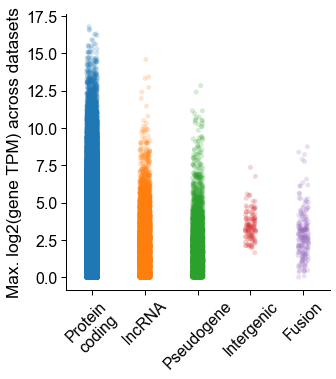

In [76]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=1.8)

order = ['protein_coding', 'lncRNA', 'pseudogene', 'Intergenic', 'Fusion']
labels = ['Protein\ncoding', 'lncRNA', 'Pseudogene', 'Intergenic', 'Fusion']

ax = sns.catplot(df, hue='gene_status', x='gene_status', y='log2_max_tpm',
                 order=order, alpha=0.2)
# ax.set(yscale='log', ylabel='Max. gene TPM across datasets', xlabel='')
ax.set(ylabel='Max. log2(gene TPM) across datasets', xlabel='')
# ax.legend.remove()
# ax.get_legend().set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", rotation=45)
ax.set_xticklabels(labels)

## How many novel readthrough loci do we detect?

In [77]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None)
df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
df = df.merge(ab_df, how='left', on='gid')

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2053: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2052: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 228876
# isos >= 1 tpm: 206731
Number of isos reported: 206731


In [80]:
n = len(df.loc[df.gene_novelty=='Fusion'].gid.unique())
print(f'Found {n} fusion loci in human')

Found 79 fusion loci in human


## How many GENCODE genes engage in readthrough transcription?

In [87]:
df = pr.read_gtf(ref_gtf, duplicate_attr=True)

In [88]:
df = df.df
df = df.loc[df.Feature=='transcript']

In [101]:
rt_df = df.loc[(df.tag.notnull())&(df.tag.str.contains('readthrough_transcript'))]
rt_df = rt_df[['gene_id', 'transcript_id']].drop_duplicates()
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gene_id')
n = len(rt_df.gene_id.unique().tolist())
print(f'Gencode v40 has {n} genes w/ annotated readthrough transcription')

Gencode v40 has 981 genes w/ annotated readthrough transcription


In [98]:
rt_df.head()

,gene_id,gid_stable
10466,ENSG00000251503.8,ENSG00000251503
11013,ENSG00000120948.19,ENSG00000120948
17404,ENSG00000285853.1,ENSG00000285853
18782,ENSG00000270136.6,ENSG00000270136
19899,ENSG00000285959.1,ENSG00000285959


## How many transcripts w/ annotated readthrough transcription do we detect?